In [4]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import mlflow

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import confusion_matrix


/home/jayakrishnan/Documents/Projects/Iris-classification/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Reading the data file using pandas library and storing its contents in a DataFrame object

df=pd.read_csv("dataset/Iris.csv")

# Displaying the first few rows of the DataFrame

df.head()


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
# Counting the number of missing values in each column of the DataFrame

df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [7]:
#drop column 'ID'

df=df.drop(columns=['Id'])

df['Species'].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [8]:
feature_names = df.columns[:-1] 
feature_names

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')

In [9]:
class_names=df.columns[-1] 
class_names

'Species'

# Data Visualization

## Violin Plots for Feature Distributions Across Iris Species

/tmp/ipykernel_29325/4157182785.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Species', y='PetalLengthCm', data=df, palette=palette)
/tmp/ipykernel_29325/4157182785.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Species', y='PetalWidthCm', data=df, palette=palette)
/tmp/ipykernel_29325/4157182785.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Species', y='SepalLengthCm', data=df, palette=palette)
/tmp/ipykernel_29325/4157182785.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated

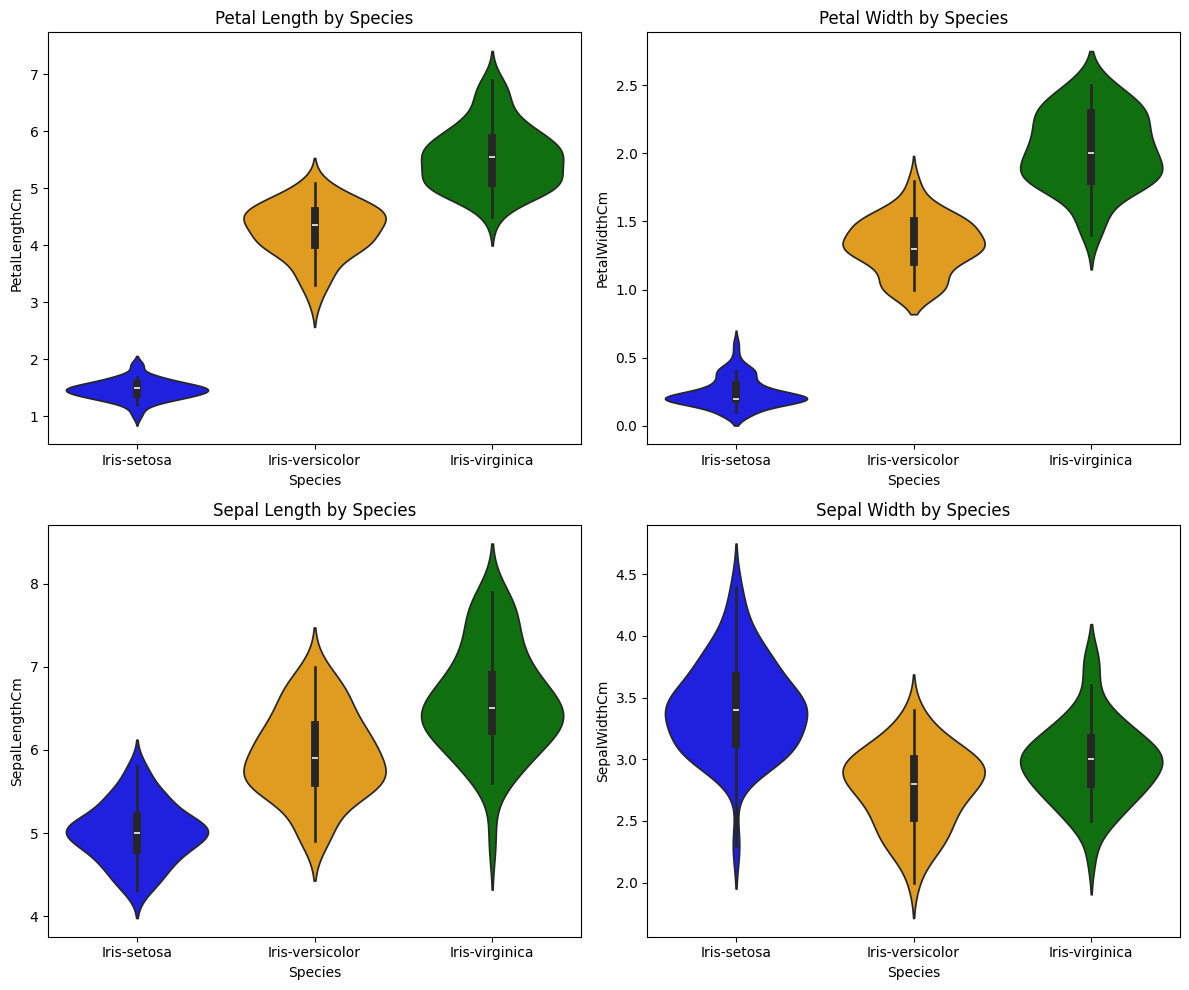

In [10]:
plt.figure(figsize=(12,10))

# Define colors for the species
palette = {'Iris-setosa': 'blue', 'Iris-versicolor': 'orange', 'Iris-virginica': 'green'}

# Petal Length
plt.subplot(2, 2, 1)
sns.violinplot(x='Species', y='PetalLengthCm', data=df, palette=palette)
plt.title('Petal Length by Species')

# Petal Width
plt.subplot(2, 2, 2)
sns.violinplot(x='Species', y='PetalWidthCm', data=df, palette=palette)
plt.title('Petal Width by Species')

# Sepal Length
plt.subplot(2, 2, 3)
sns.violinplot(x='Species', y='SepalLengthCm', data=df, palette=palette)
plt.title('Sepal Length by Species')

# Sepal Width
plt.subplot(2, 2, 4)
sns.violinplot(x='Species', y='SepalWidthCm', data=df, palette=palette)
plt.title('Sepal Width by Species')

# Adjust layout
plt.tight_layout()
plt.show()


## Pair Plot for Visualization

/home/jayakrishnan/Documents/Projects/Iris-classification/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


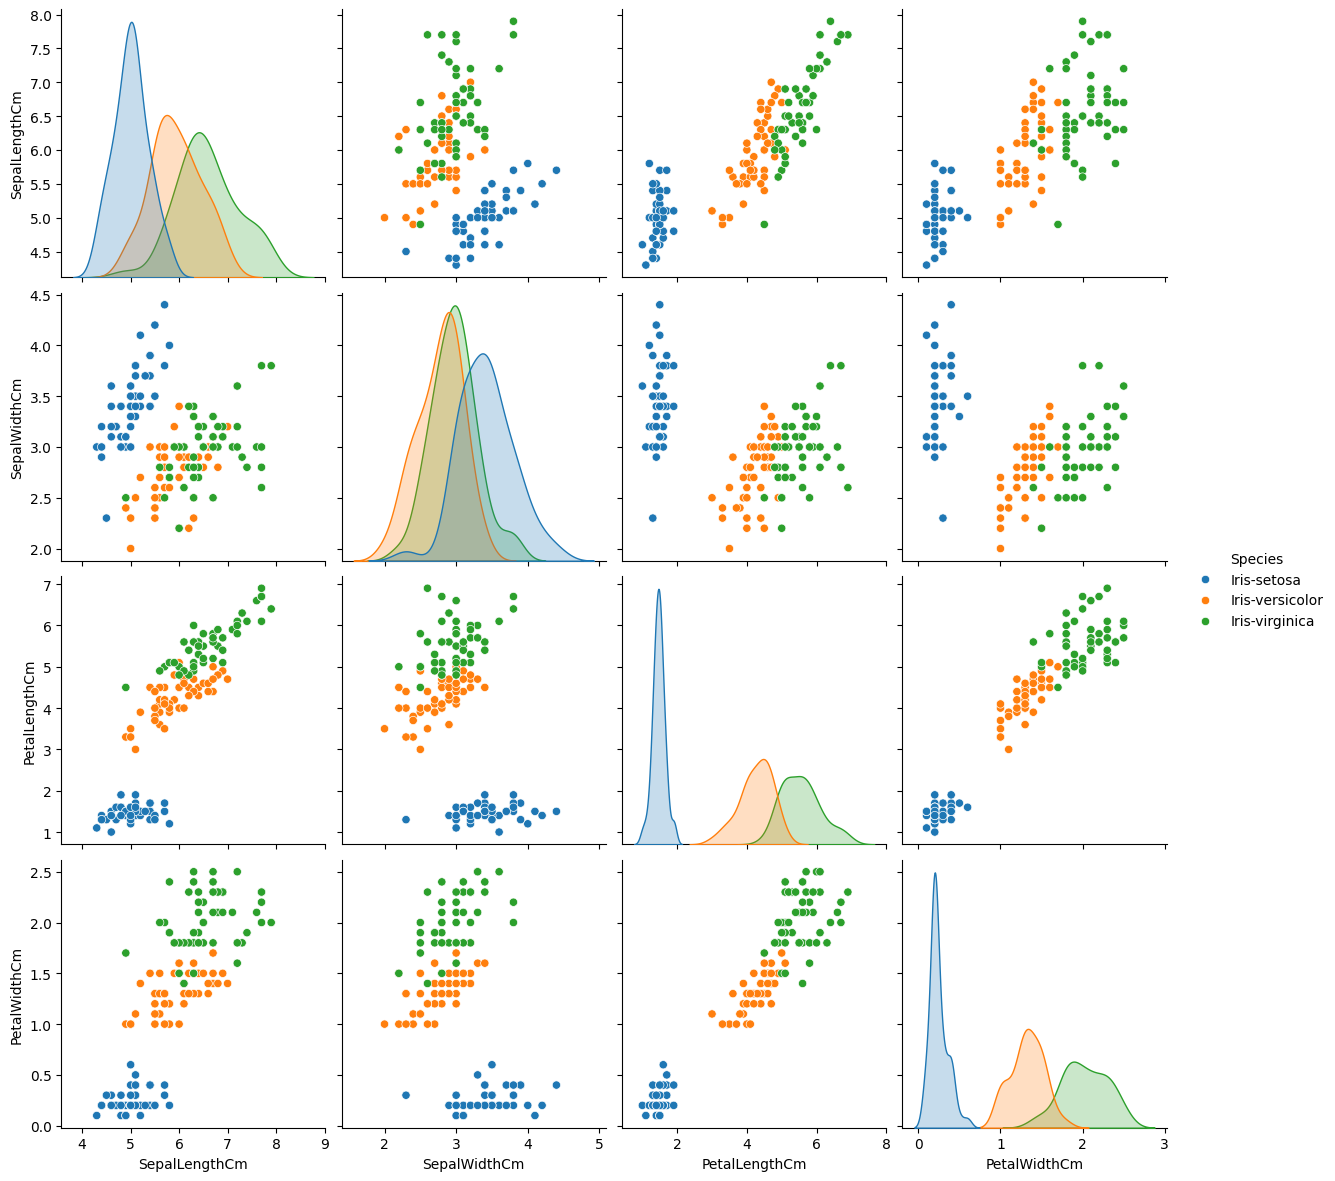

In [11]:
sns.pairplot(df, hue="Species", size=3)

In [12]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

df['Species']=le.fit_transform(df['Species'])
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [13]:
#Train-test split
#test=30 # train=70


X=df.drop(columns=['Species'])
Y=df['Species']
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=42)

In [14]:
## Standardze the dataset

from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()


X_train = scalar.fit_transform(x_train)
X_test =scalar.fit_transform(x_test)

# Hyperparameter optimization and Training

In [15]:

# Define the objective function for Optuna optimization
def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_loguniform('C', 1e-5, 100)  # Regularization parameter
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])  # Kernel type
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])  # Kernel coefficient

    # Initialize SVC with the hyperparameters
    model = SVC(C=C, kernel=kernel, gamma=gamma)

    # Perform cross-validation to evaluate the model
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

# Create an Optuna study to optimize the objective function
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)




[I 2024-11-21 15:20:52,248] A new study created in memory with name: no-name-449b0bd8-1600-41b5-b0d7-07f2b563a94d
/tmp/ipykernel_29325/2967292366.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 100)  # Regularization parameter
[I 2024-11-21 15:20:52,263] Trial 0 finished with value: 0.9428571428571428 and parameters: {'C': 41.8614340696473, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.9428571428571428.
/tmp/ipykernel_29325/2967292366.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 100)  # Regularization parameter
[I 2024-11-21 15:20:52,275] Trial 1 finished wit

In [16]:
# After optimization, you can access the best hyperparameters like this:
best_params = study.best_params
print("Best parameters found: ", best_params)



Best parameters found:  {'C': 8.415316062303356, 'kernel': 'linear', 'gamma': 'auto'}


In [25]:
best_params


{'C': 8.415316062303356, 'kernel': 'linear', 'gamma': 'auto'}

In [17]:
# Now you can use the optimized parameters to train the final SVC model
best_model = SVC(**best_params,probability=True)

In [18]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    precision = precision_score(actual, pred, average='weighted')
    recall = recall_score(actual, pred, average='weighted')
    f1 = f1_score(actual, pred, average='weighted')
    mse = mean_squared_error(actual, pred)
    return accuracy, precision, recall, f1, mse

mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_tracking_uri(None)

# Set experiment name
mlflow.set_experiment(experiment_name='Iris-Classification')

# Start an MLflow run
with mlflow.start_run():

    # Train the Logistic Regression Model
    Classifier = best_model
    # Train the model
    Classifier.fit(x_train, y_train)

    # Make predictions
    y_test_hat = Classifier.predict(x_test)

    # # Calculate metrics
    # mse = mean_squared_error(y_test, y_test_hat)
    # accuracy = accuracy_score(y_test, y_test_hat)
    (accuracy, precision, recall, f1, mse) = eval_metrics(y_test, y_test_hat)

    print(f"Classifier model")
    print("  Accuracy: %s" % accuracy)
    print("  Precision: %s" % precision)
    print("  Recall: %s" % recall)
    print("  F1 Score: %s" % f1)
    print("  mse: %s" % mse)

    
    # Log parameters and metrics
    mlflow.log_param('model_type', 'Linear Regression')
    mlflow.log_params(best_params)
    mlflow.log_metrics({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "mse": mse
        })
    
    # Log model
    mlflow.sklearn.log_model(Classifier, 'model')

Classifier model
  Accuracy: 0.9777777777777777
  Precision: 0.9793650793650793
  Recall: 0.9777777777777777
  F1 Score: 0.9777448559670782
  mse: 0.022222222222222223


2024/11/21 15:21:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/21 15:21:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-owl-77 at: http://127.0.0.1:5000/#/experiments/1/runs/a01a5200639441bfbe4fd5f119049c86.
2024/11/21 15:21:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [19]:
flower_mapping = {0: 'setosa', 1: 'versicolor ', 2: 'virginica '}

test_instance = x_test.iloc[2].values.reshape(1, -1)
output= Classifier.predict(test_instance)[0]
flower_mapping.get(output)

/home/jayakrishnan/Documents/Projects/Iris-classification/venv/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


'virginica '

In [20]:
# Predicting the target variable using the trained model and the test data
y_test_hat = Classifier.predict(x_test)

# Creating a DataFrame to store the actual and predicted values of the target variable
Results = pd.DataFrame({'Actual': y_test, 'Predictions': y_test_hat})

# Displaying the first 5 rows of the Results DataFrame
Results.head(5)

,Actual,Predictions
73,1,1
18,0,0
118,2,2
78,1,1
76,1,1


### Pickling Trained Model

In [ ]:
# import pickle
    
# with open('reg_model.pkl', 'wb') as file:
#     pickle.dump(Classifier, file)

# Evaluation

[[19  0  0]
 [ 0 12  1]
 [ 0  0 13]]


Text(95.72222222222221, 0.5, 'True Label')

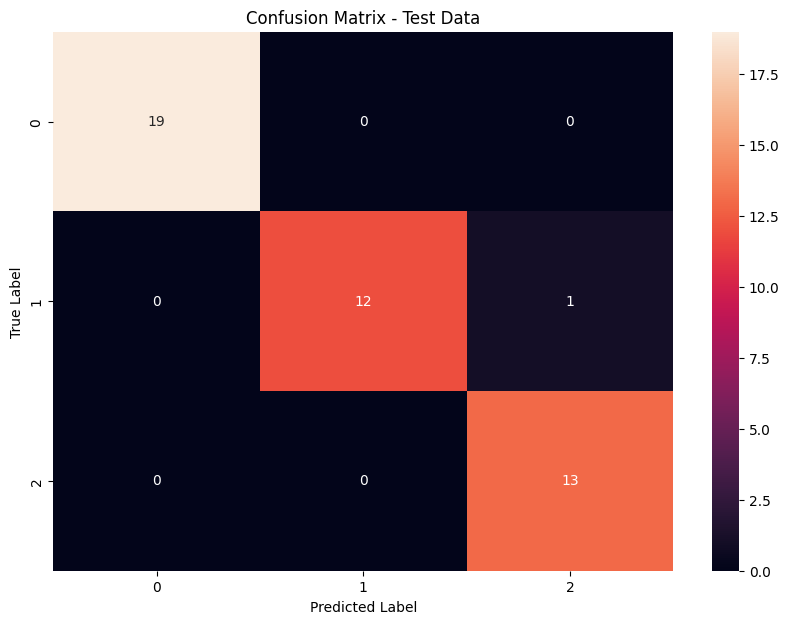

In [22]:
# Calculate the confusion matrix for the test set and output it to the console.
cm = confusion_matrix(y_test,y_test_hat)
print(cm)

# Importing the seaborn library for visualization
import seaborn as sn

# Creating a heatmap using the confusion matrix with annotations
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)

# Setting the title, x-label and y-label of the heatmap
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [23]:
# Import the classification_report function from sklearn.metrics module
from sklearn.metrics import classification_report

print(classification_report(y_test,y_test_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



# Explainability

/home/jayakrishnan/Documents/Projects/Iris-classification/venv/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


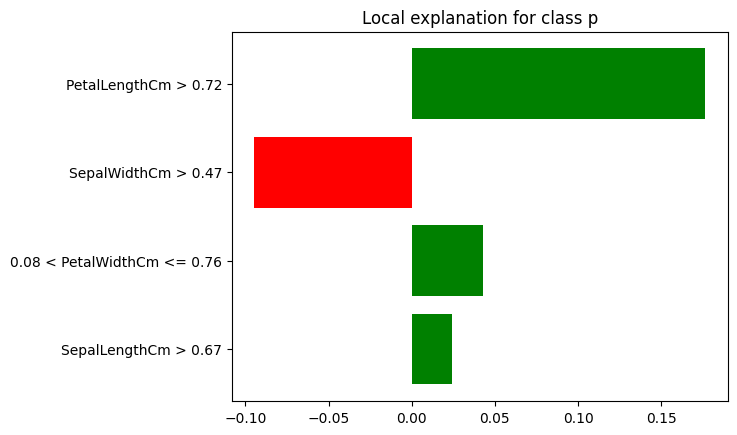

In [24]:
import lime
import lime.lime_tabular

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    training_labels=y_train,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Select a test instance for explanation
idx = 1  # Index of a test sample
test_instance = x_test.iloc[idx].values.reshape(1, -1)  # Convert to numpy array

# Explain the prediction for the selected instance
explanation = explainer.explain_instance(test_instance[0], Classifier.predict_proba, num_features=4)

# Show the explanation
explanation.show_in_notebook()

# Or plot the explanation
explanation.as_pyplot_figure()
plt.show()
